# **DSCI100 002 Final Project**
*By Shayda Yellowknee, 17359985*

We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.


#### **INTRODUCTION**

##### Background:

Minecraft, an open-ended adventure game, was first released in November 2011 (Heaney, 2023), encouraging creativity and fun from players of all ages worldwide. Players, along with friends, can build servers where they can mine in caves, craft materials from natural resources, build houses, or even fight a dragon. The game has no set goals, and players can use their imagination to explore both the game and their inner creativity. Due to its open ended-ness, player demographics vary worldwide, with many having grown up with it as it was developed, and others just being introduced to it now. Players consist of all ages and genders, leading to a wide range of playtime patterns. Understanding what factors influence the playtime of a player can provide meaningful insight into different demographics engagement and behaviour with the game. 

##### Question: **Can a player's age predict the total time they spend playing on Minecraft?**



##### Data Description:
In this analysis, we will explore whether a player's age can be used to predict their total playtime on Minecraft, with data collected using a research server created by a team at UBC (https://plai.cs.ubc.ca/), led by Frank Wood. 
The data consists of two files: 
1. `players.csv` - Consists of self-reported demographic information of players. 
2. `sessions.csv` - Consists of login and logout time data for each of the player's Minecraft sessions.

`players.csv` variable summary:
- Number of observations: 196 players
- `experience` - Self-reported Minecraft experience: beginner, regular, amateur, pro, veteran
- `subscribe` - Whether or not the player is subscribed to a game-related newsletter: TRUE or FALSE
- `hashedEmail` - Email provided by player, identifier for each player
- `played_hours` - Time spent playing minecraft, in hours
- `name` - Name provided by players
- `gender` - Gender of player: Male, female, non-binary, two-spirited, prefer not to say
- `Age` - Age of player: 8-50

`sessions.csv` variable summary:
- Number of Minecraft sessions played: 1535
- `hashedEmail` - Email provided by player, identifier for each player
- `start_time` - Character string of start date and times (dd/mm/yyyy)
- `end_time` - Character string of end date and times (dd/mm/yyyy)
- `original_start_time` - Raw timestamp of start times, in milliseconds
- `original_end_time` - Raw timestamp of end times, in milliseconds

Data tidying and limitations: 
- The datasets contain missing values, which are to be removed during the tidying of data
- Variables like experience and age are self-reported, so potential inaccuracies may occur
- Timestamp data must be converted to from character strings to date-time object

#### **METHODS AND RESULTS**

In this data analysis, we:
- Loaded two datasets: `players.csv` and `sessions.csv`
- Cleaned the session data:
  - Converting date-time strings into datetime
  - Calculating session length in minutes
  - Summarized total playtime and the number of sessions per play
- Cleaned the players data
- Merged the players and sessions data using hashed_email
- Filtered out rows with missing age or total playtime values
- Visualized this relationship between age and total playtime with a scatterplot
- Split the cleaned dataset into 75% training set and 25% testing sets
- Build a linear regression model to predict total playtime from age
- Evaluated the performance of the model using RMSE
- Plotted the predicted values against actual data

In [79]:
#load libraries
library(tidyverse)
library(repr)
library(lubridate)
library(tidymodels)
library(janitor)
options(repr.matrix.max.rows = 6)

In [80]:
#read in data
players<-read_csv("players.csv")
sessions<-read_csv("sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [81]:
#inspect data
players
sessions

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


In [82]:
#preparing sessions data
#calculating total playtime per player

sessions_clean<-sessions|>
mutate(start_time=dmy_hm(start_time),
       end_time=dmy_hm(end_time),
      session_minutes=as.numeric(end_time-start_time)/60)|>
clean_names() #renames columns from hashedEmail to hashed_email

sessions_clean

player_sessions_summary<-sessions_clean|>
group_by(hashed_email)|>
summarize(total_minutes=sum(session_minutes, na.rm=TRUE), 
          session_count=n())

player_sessions_summary

hashed_email,start_time,end_time,original_start_time,original_end_time,session_minutes
<chr>,<dttm>,<dttm>,<dbl>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30 18:12:00,2024-06-30 18:24:00,1.71977e+12,1.71977e+12,0.2000000
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17 23:33:00,2024-06-17 23:46:00,1.71867e+12,1.71867e+12,0.2166667
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25 17:34:00,2024-07-25 17:57:00,1.72193e+12,1.72193e+12,0.3833333
⋮,⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2024-07-28 15:36:00,2024-07-28 15:57:00,1.72218e+12,1.72218e+12,0.3500000
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2024-07-25 06:15:00,2024-07-25 06:22:00,1.72189e+12,1.72189e+12,0.1166667
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-20 02:26:00,2024-05-20 02:45:00,1.71617e+12,1.71617e+12,0.3166667


hashed_email,total_minutes,session_count
<chr>,<dbl>,<int>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,1.7666667,2
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,0.5000000,1
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,0.1833333,1
⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,79.91667,310
fe218a05c6c3fc6326f4f151e8cb75a2a9fa29e22b110d4c311fb58fb211f471,0.15000,1
fef4e1bed8c3f6dcd7bcd39ab21bd402386155b2ff8c8e53683e1d2793bf1ed1,1.20000,1


In [83]:
#clean players data

players_clean<-players|>
clean_names()|>
mutate(age=as.numeric(age))

players_clean


experience,subscribe,hashed_email,played_hours,name,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [84]:
#join players data with sessions summary

minecraft_data<-players_clean|>
left_join(player_sessions_summary, by="hashed_email")|>
filter(!is.na(age),
       !is.na(total_minutes)) #filtering out missing age/total_minutes values, cleaning data

minecraft_data

experience,subscribe,hashed_email,played_hours,name,gender,age,total_minutes,session_count
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,33.65000000,27
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,4.25000000,3
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,0.08333333,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22,0.35000000,1
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17,0.08333333,1
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17,2.98333333,6


In [85]:
#Summary of dataset
dim(minecraft_data)

[1] 123   9

In [86]:
summary(minecraft_data)

  experience        subscribe       hashed_email        played_hours    
 Length:123         Mode :logical   Length:123         Min.   :  0.000  
 Class :character   FALSE:32        Class :character   1st Qu.:  0.100  
 Mode  :character   TRUE :91        Mode  :character   Median :  0.400  
                                                       Mean   :  9.313  
                                                       3rd Qu.:  1.500  
                                                       Max.   :223.100  
     name              gender               age        total_minutes      
 Length:123         Length:123         Min.   : 8.00   Min.   :  0.08333  
 Class :character   Class :character   1st Qu.:17.00   1st Qu.:  0.18333  
 Mode  :character   Mode  :character   Median :19.00   Median :  0.55000  
                                       Mean   :20.61   Mean   : 10.56138  
                                       3rd Qu.:22.50   3rd Qu.:  1.80000  
                                       

From these summaries, we can see that there is 123 observations/players, and 9 variables.

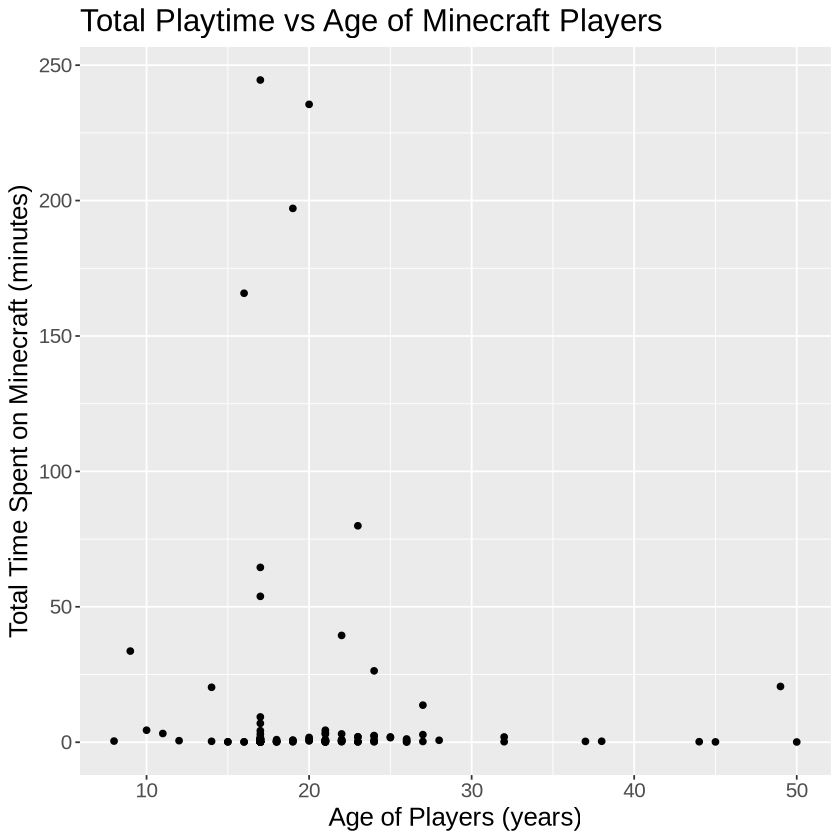

In [87]:
#visualize this data

minecraft_plot<-ggplot(minecraft_data, aes(x=age, y=total_minutes))+
geom_point()+
labs(x="Age of Players (years)", y="Total Time Spent on Minecraft (minutes)",
     title="Total Playtime vs Age of Minecraft Players")+
theme(text=element_text(size=15.5))

minecraft_plot

Figure 1. Scatterplot showing the relationship between player age and total time spent playing Minecraft (minutes).

From this scatterplot, there does not appear to be a strong relationship between age and total Minecraft playtime, as the points are concentrated in ages 14-27, and more scattered in ages <14 and >27. There are some extreme outliers, likely from self-reported veteran players.

In [88]:
#create training set and testing set
set.seed(123)

minecraft_split<-initial_split(minecraft_data, prop=0.75, strata=total_minutes)
minecraft_train<-training(minecraft_split)
minecraft_test<-testing(minecraft_split)

We will do linear regression on the data because age, the exploratory variable, is numeric, and we are trying to understand its relationship to its response variable, total_minutes, which is also numeric. This method will increase interpretability. Choosing this method implies that a linear relationship is to be expected, and that data points will be distributed normally. The age variable itself may be a limitation as it may not be a strong predictor, though we must continue forward with the analysis. 

Here, choosing a 75/25 training/testing split provides a balanced proportion of data we will use to train the model on, and data we will test the model on. It is a common split used in data analysis.

In [89]:
#create linear regression model
lm_spec<-linear_reg()|>
set_engine("lm")|>
set_mode("regression")

In [90]:
#create recipe
lm_recipe<-recipe(total_minutes~ age, data=minecraft_train)

In [91]:
lm_fit<-workflow()|>
add_recipe(lm_recipe)|>
add_model(lm_spec)|>
fit(data=minecraft_train)

In [92]:
lm_test_results<-lm_fit|>
predict(minecraft_test)|>
bind_cols(minecraft_test)|>
metrics(truth=total_minutes, estimate=.pred)

print(lm_test_results)

# A tibble: 3 × 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 rmse    standard     30.4   
2 rsq     standard      0.0169
3 mae     standard     16.5   


Here, we can see that RMSE=30.4, which means that the predictions that the model makes are ~30.4 minutes off from the actual total playtime.

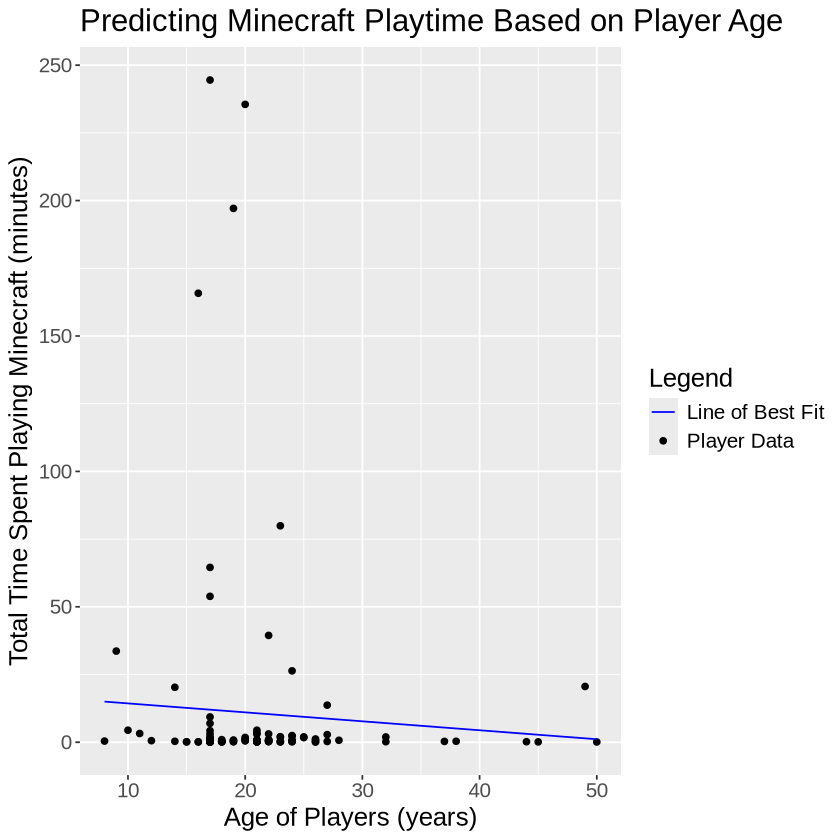

In [93]:
#visualize!
lm_preds<-lm_fit|>
predict(minecraft_data)|>
bind_cols(minecraft_data)

minecraft_preds_plot<- ggplot(lm_preds, aes(x=age, y=total_minutes))+
geom_point(aes(color="Player Data"))+
geom_line(aes(y=.pred, color="Line of Best Fit"))+
labs(x="Age of Players (years)", y= "Total Time Spent Playing Minecraft (minutes)",
     title="Predicting Minecraft Playtime Based on Player Age",
    color="Legend")+
scale_color_manual( values=c("Player Data"= "black", "Line of Best Fit" = "blue"))+
theme(text=element_text(size=15.5))

minecraft_preds_plot

Figure 2. Predicted Minecraft playtime based on player age, using a fitted linear regression line (blue).

From this plot, we can see that there is no clear trend or pattern between a player's age and their total Minecraft playtime. The blue line of best fit is nearly flat, implying that age does not have a significant impact on how much a player spends on the game. Data points are scattered, suggesting high variability in playtime across ages. 

#### **DISCUSSION**

This data analysis explored whether a player's age is able to predict the amount of time they would spend playing Minecraft. By using a linear regression model, we can conclude that age is a very weak predictor of how much time a person will spend on the game. We can see this in both the linear regression plot and the calculated RMSE value, which was decently high (30.4 minutes), meaning that there is more error in the predictions. The line of best fit is nearly flat, and the lack of patterns, likely caused by outliers, demonstrates that insignificant impact that age will have on predicting the gameplay. 


This was not what I was expecting to find. With Minecraft's large fanbase of young children, I expected that younger kids (<14 years old) would automatically have high total playtimes, as they are obsessed with the game, but I did not consider the other variables that may also impact these results, lots of which were not tested or included in the two datasets, such as scheduling (with school and extracurriculars) and motivation. Age alone is too simple to explain the behaviour we found. 


Due to the weak relationship between age and total playtime, it is unlikely that these findings will have any impact on determining which "kinds" of players are most likely to contribute data to Minecraft recruiting efforts. This highlights the importance of considering multiple variables when analyzing the behavior of Minecraft players.

##### Future questions:
This analysis leaves room for Frank Wood's research team to analyze further. 
- Do combinations of variables such as age, gender, and experience predict playtime more effectively?
- Are there any groups that form due to patterns in age, gender, and experience?
- How does self-reported experience contribute to the amount of time spent playing Minecraft?  


#### **REFERENCES**
Heaney, Samuel. (2023). *The History and Evolution of Minecraft*. Retrieved from https://www.ign.com/articles/the-history-and-evolution-of-minecraft